In [8]:
import os
# 이미지 다운
if not os.path.exists('train2017'):
    # 파일이 존재하지 않을 때 실행할 코드
    !wget http://images.cocodataset.org/zips/train2017.zip
    !unzip train2017.zip
    
# 캡션 다운
if not os.path.exists('annotations'):
    # 파일이 존재하지 않을 때 실행할 코드
    !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
    !unzip annotations_trainval2017.zip

In [9]:
# 데이터 분할
# dataPrepare.py에서 데이터 비율 및 vocab을 정의할 수 있다.
if not os.path.exists('dataset'):
    !python3 data_prepare.py

[nltk_data] Downloading package punkt to /home/whitdisa04/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
data_prepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.LANCZOS)
data_prepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.LANCZOS)
data_prepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.LANCZOS)
data_prepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.LANCZOS)
data_prepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resamplin

In [10]:
batch_size = 32
learning_rate = 0.0002
num_epochs = 5
num_workers = 6

# Increase Model Capacity
embed_size = 256
hidden_size = 1024
num_layers = 1

In [11]:
import os
import pickle
import torch
from torchvision import transforms
from data_loader import get_loader
from model_transformer_lstm import *

In [12]:
img_dir = ["./dataset/train/images", "./dataset/val/images", "./dataset/test/images"] 

train_img_path = img_dir[0] # resized image for training
val_img_path = img_dir[1] # resized image for validation
test_img_path = img_dir[2] # resized image for test

coco_caption_path = "./annotations/captions_train2017.json"
train_caption_path = "./dataset/train/captions.txt" # resized image for training
val_caption_path = "./dataset/val/captions.txt" # resized image for validation
test_caption_path = "./dataset/test/captions.txt" # resized image for test

vocab_path = "./dataset/vocab.pkl"  # Path to the preprocessed vocabulary file
# Load vocabulary file
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

model_path = "models/"  # Path where the trained model will be saved
# Create model directory
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [13]:
# Use the same preprocessing and normalization parameters as were applied in the pre-trained Inception model.
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([
    transforms.Resize(224),  # Adjust to the correct size for Inception
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
    transforms.Resize(224),  # Adjust to the correct size for Inception
    transforms.ToTensor()
])

# Declare data loaders
train_data_loader = get_loader(train_img_path, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False, pin_memory=True)
val_data_loader = get_loader(val_img_path, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False, pin_memory=True)
test_data_loader = get_loader(test_img_path, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True, pin_memory=True)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = ViTEncoder(embed_size).to(device)
decoder = LSTMDecoder(embed_size, hidden_size, len(vocab), num_layers).to(device)
# Criterion with ignore_index to skip pad tokens
criterion = nn.CrossEntropyLoss(ignore_index=vocab('<pad>'))
params = list(decoder.parameters()) + list(encoder.linear.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

# Gradient clipping value
clip_value = 5

# Learning rate scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [15]:
# 평가 함수 정의
def evaluate(encoder, decoder, data_loader, criterion, device):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions, lengths in data_loader:
            images, captions = images.to(device), captions.to(device)
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return round(total_loss / len(data_loader), 4)

In [16]:
from tqdm import tqdm

# 훈련 손실 누적
train_losses = []
val_losses = []
# Training loop
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()

    train_loss = 0  # 에포크 시작 전 훈련 손실 초기화
    with tqdm(enumerate(train_data_loader), total=len(train_data_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as t:
        for i, (images, captions, lengths) in t:
            # Move batch of images and captions to GPU if available
            images, captions = images.to(device), captions.to(device)

            # Forward pass through encoder and decoder
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # Calculate the batch loss based on the criterion
            loss = criterion(outputs, targets)
            train_loss += loss.item()  # 각 배치의 손실 누적
            decoder.zero_grad()
            encoder.zero_grad()

            # Backward pass (compute gradients)
            loss.backward()

            # Clip gradients
            clip_params = list(encoder.parameters()) + list(decoder.parameters())
            torch.nn.utils.clip_grad_norm_(clip_params, clip_value)
            # Update the weights
            optimizer.step()

            # Update tqdm's description with the current loss
            t.set_postfix(loss=loss.item())

            # Log training statistics and save model checkpoints
        if  (epoch+1) % 1 == 0:
            torch.save(decoder.state_dict(), os.path.join(model_path, 'decoder-{}.ckpt'.format(epoch+1)))
            torch.save(encoder.state_dict(), os.path.join(model_path, 'encoder-{}.ckpt'.format(epoch+1)))
    # 에포크가 끝날 때 평균 훈련 손실 계산 및 기록
    train_loss /= len(train_data_loader)
    train_loss = round(train_loss, 4)
    train_losses.append(train_loss)

    # 검증 손실 계산 및 기록
    val_loss = evaluate(encoder, decoder, val_data_loader, criterion, device)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

    # Learning rate scheduler update는 에포크 끝에서 한 번만 수행
    # scheduler.step()


Epoch 1/5: 100%|██████████| 1250/1250 [06:30<00:00,  3.20it/s, loss=3.2] 


Epoch 1, Training Loss: 3.6124, Validation Loss: 3.0795


Epoch 2/5: 100%|██████████| 1250/1250 [06:30<00:00,  3.20it/s, loss=2.43]


Epoch 2, Training Loss: 2.7883, Validation Loss: 2.6815


Epoch 3/5: 100%|██████████| 1250/1250 [06:30<00:00,  3.20it/s, loss=2.21]


Epoch 3, Training Loss: 2.4788, Validation Loss: 2.5364


Epoch 4/5: 100%|██████████| 1250/1250 [06:30<00:00,  3.20it/s, loss=2.14]


Epoch 4, Training Loss: 2.2973, Validation Loss: 2.4635


Epoch 5/5: 100%|██████████| 1250/1250 [06:30<00:00,  3.20it/s, loss=2.01]


Epoch 5, Training Loss: 2.1584, Validation Loss: 2.4155


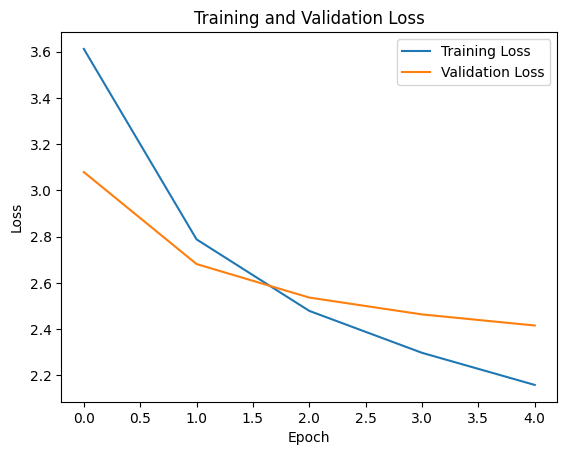

In [17]:
# 추가: 훈련 및 검증 손실 그래프 그리기
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

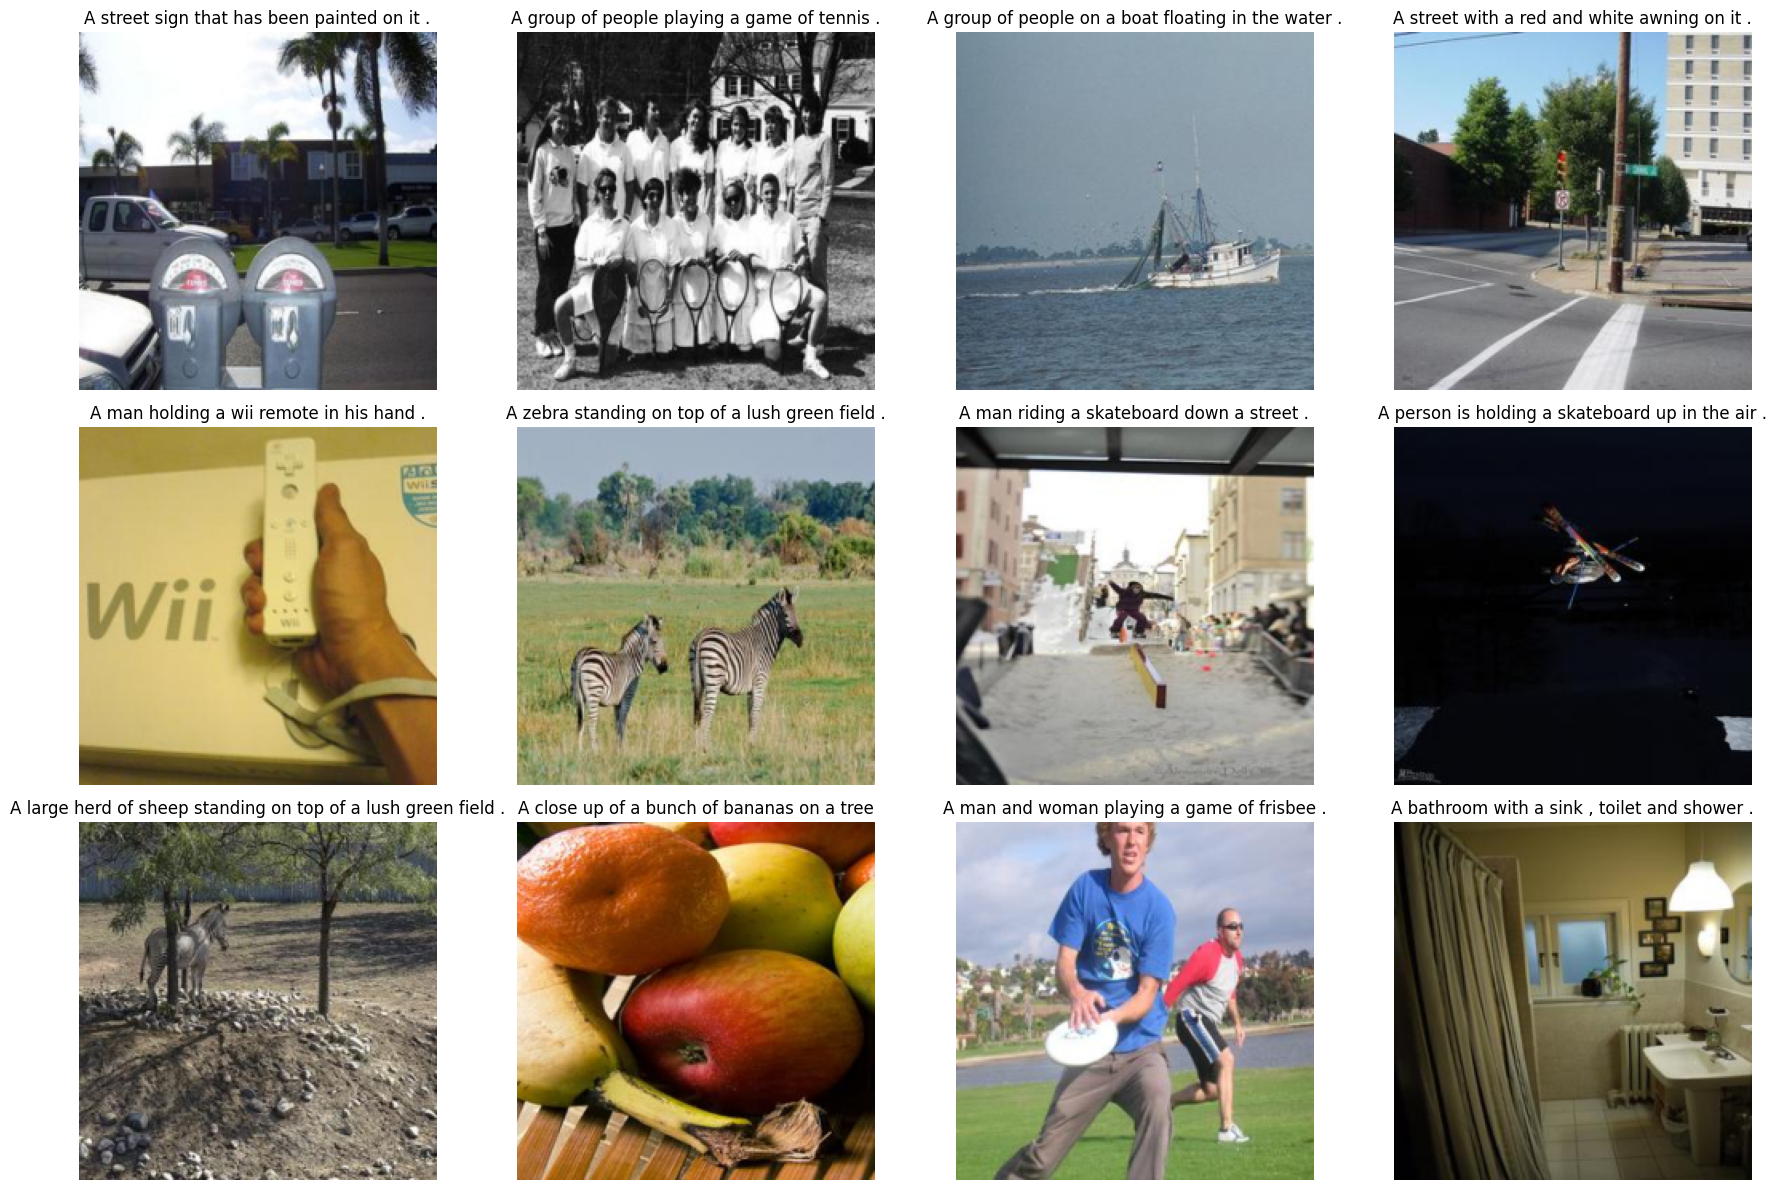

In [22]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image

# 모델과 데이터 로더 설정
encoder = ViTEncoder(embed_size).to(device)
decoder = LSTMDecoder(embed_size, hidden_size, len(vocab), num_layers).to(device)

# 모델 가중치 로드
encoder.load_state_dict(torch.load('./models/encoder-5.ckpt'))
decoder.load_state_dict(torch.load('./models/decoder-5.ckpt'))

# 테스트 모드 설정
encoder.eval()
decoder.eval()

# 테스트 데이터셋에서 랜덤으로 10개의 이미지 선택
test_images = []
for _ in range(12):
    idx = random.randint(0, len(test_data_loader.dataset) - 1)
    image, _ = test_data_loader.dataset[idx]
    test_images.append(image)

# 이미지와 캡션 출력
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))
axes = axes.flatten()

for i, image in enumerate(test_images):
    image = image.to(device)
    feature = encoder(image.unsqueeze(0))
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()

    # 캡션 변환
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption[1:-1]).capitalize()

    # 이미지 출력
    image = image.cpu().numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(sentence)

plt.tight_layout()
plt.show()

In [23]:
"""
각 n-gram 수준(1-gram, 2-gram, 3-gram, 4-gram)에서 생성된 캡션과 참조 캡션 간의 일치도를 계산합니다.
이러한 각각의 n-gram 일치도에 대해 동일한 가중치(기본적으로 각각 0.25)를 부여하여, 이들의 평균을 계산합니다.
이 평균 점수가 최종 BLEU 점수가 됩니다.
"""
import torchtext.data.metrics as metrics

def calculate_bleu(data_loader, encoder, decoder, vocab, device):
    predictions = []
    references = []
    with torch.no_grad():
        for images, captions, _ in data_loader:
            images = images.to(device)
            features = encoder(images)
            sampled_ids = decoder.sample(features)
            sampled_ids = sampled_ids.cpu().numpy()

            # Convert word_ids to words
            for i in range(len(images)):
                sampled_caption = []
                for word_id in sampled_ids[i]:
                    word = vocab.idx2word[word_id]
                    sampled_caption.append(word)
                    if word == '<end>':
                        break
                predictions.append(sampled_caption[1:-1])

                # Original sentence
                orig_caption = []
                for word_id in captions[i].numpy():
                    word = vocab.idx2word[word_id]
                    orig_caption.append(word)
                    if word == '<end>':
                        break
                references.append([orig_caption[1:-1]])

    bleu1_score = metrics.bleu_score(predictions, references, max_n=4, weights=[1, 0, 0, 0])
    bleu2_score = metrics.bleu_score(predictions, references, max_n=4, weights=[0, 1, 0, 0])
    bleu3_score = metrics.bleu_score(predictions, references, max_n=4, weights=[0, 0, 1, 0])
    bleu4_score = metrics.bleu_score(predictions, references, max_n=4, weights=[0, 0, 0, 1])

    # 변경: BLEU 점수 계산 결과를 다른 변수에 할당
    return bleu1_score, bleu2_score, bleu3_score, bleu4_score

# 모델의 일반화 능력 평가
bleu_score = calculate_bleu(test_data_loader, encoder, decoder, vocab, device)
for idx, bleu in enumerate(bleu_score):
    print(f'BLEU {idx + 1} Score: {round(bleu, 4)}')

BLEU 1 Score: 0.3651
BLEU 2 Score: 0.0977
BLEU 3 Score: 0.0337
BLEU 4 Score: 0.0145
